In [4]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
#2.MNIST 데이터셋 load

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # [-1, 1] 범위로 정규화
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.45MB/s]


In [7]:
# 하이퍼파라미터
z_dim = 16
epochs = 5          # 빠른 확인용. 품질을 더 보려면 10~20으로 늘려보세요.
lr_rec = 2e-4       # Encoder+Decoder (재구성)
lr_adv = 2e-4       # Discriminator 및 Encoder 적대학습
beta1, beta2 = 0.5, 0.999

# 모델 정의
class Encoder(nn.Module):
    def __init__(self, in_ch=1, z_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),

            nn.Flatten(),
            nn.Linear(64*7*7, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, True),

            nn.Linear(256, z_dim)
        )
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, out_ch=1, z_dim=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),

            nn.Linear(256, 64*7*7),
            nn.BatchNorm1d(64*7*7),
            nn.ReLU(True),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 7->14
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, out_ch, 4, 2, 1),  # 14->28
            nn.Tanh()
        )
    def forward(self, z):
        h = self.fc(z).view(-1, 64, 7, 7)
        return self.deconv(h)

class DiscriminatorZ(nn.Module):
    def __init__(self, z_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 1)  # logits
        )
    def forward(self, z):
        return self.net(z).squeeze(-1)

[1/5] rec: 0.1033 | C: 0.6927 | Gz: 0.6977


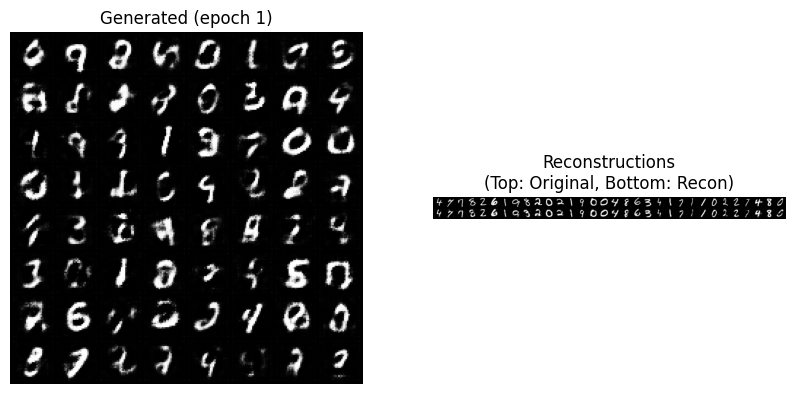

[2/5] rec: 0.0892 | C: 0.6943 | Gz: 0.6954


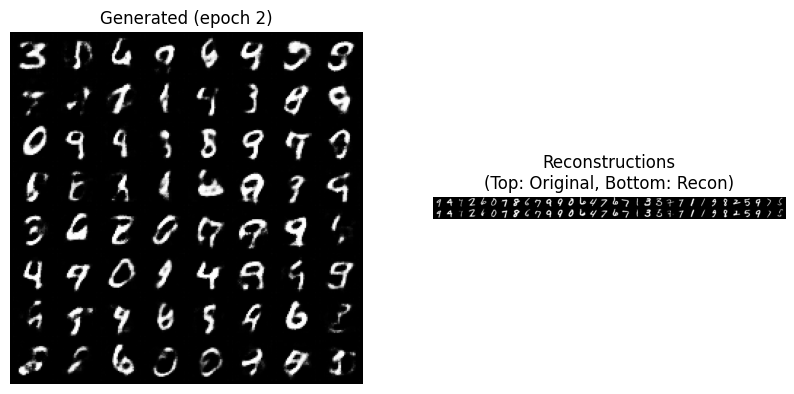

[3/5] rec: 0.0869 | C: 0.6844 | Gz: 0.7122


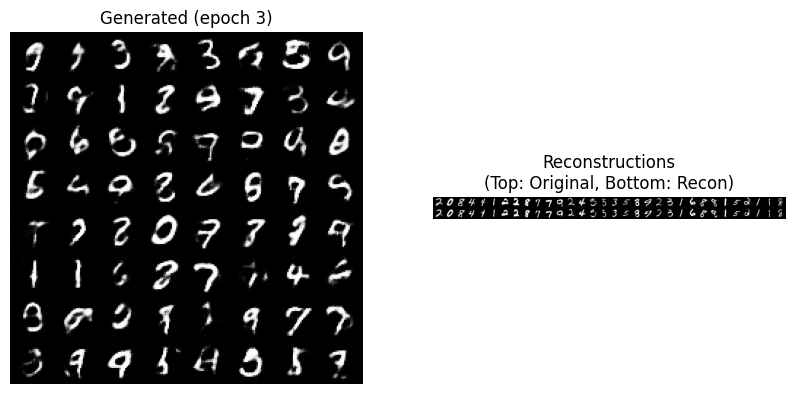

[4/5] rec: 0.0768 | C: 0.6860 | Gz: 0.7010


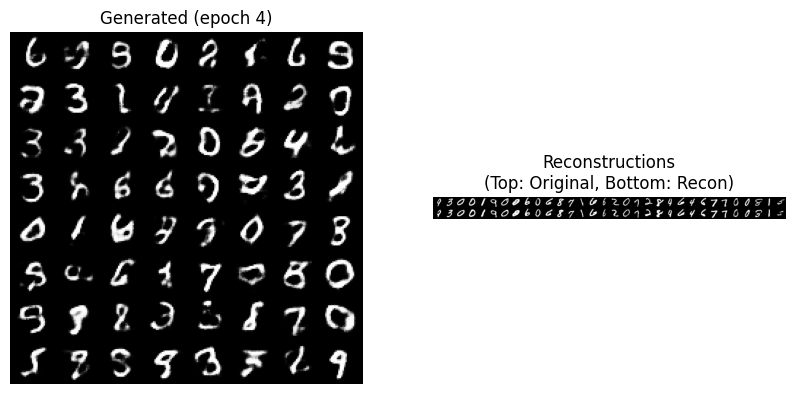

[5/5] rec: 0.0779 | C: 0.6908 | Gz: 0.6980


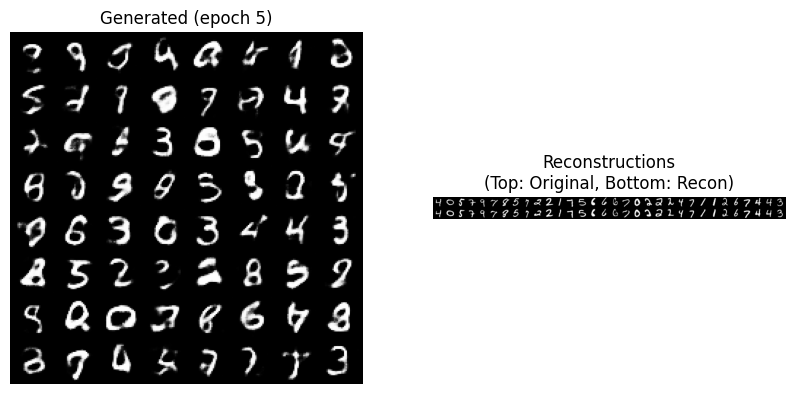

In [8]:
# 모델 초기화
E = Encoder(1, z_dim).to(device)
D = Decoder(1, z_dim).to(device)
C = DiscriminatorZ(z_dim).to(device)

# 옵티마이저와 손실
opt_rec = torch.optim.Adam(list(E.parameters()) + list(D.parameters()), lr=lr_rec, betas=(beta1, beta2))
opt_c   = torch.optim.Adam(C.parameters(), lr=lr_adv, betas=(beta1, beta2))
opt_gz  = torch.optim.Adam(E.parameters(), lr=lr_adv, betas=(beta1, beta2))

recon_loss_fn = nn.L1Loss()
bce_logits = nn.BCEWithLogitsLoss()

# 유틸
def sample_prior(n, z_dim, device):
    return torch.randn(n, z_dim, device=device)

@torch.no_grad()
def show_epoch_results(epoch, E, D, train_loader, device):
    # 생성 샘플
    E.eval(); D.eval()
    z = sample_prior(64, z_dim, device)
    gen = D(z)  # [-1,1]
    grid_gen = make_grid(gen, nrow=8, normalize=True, value_range=(-1,1))  # [0,1]

    # 재구성 비교 (윗줄: 원본, 아랫줄: 복원)
    x, _ = next(iter(train_loader))
    x = x.to(device)
    rec = D(E(x))
    both = torch.cat([x[:32], rec[:32]], dim=0)  # [-1,1]
    grid_rec = make_grid(both, nrow=32, normalize=True, value_range=(-1,1))  # [0,1]

    # 시각화
    def imshow(grid, title):
        npimg = grid.permute(1, 2, 0).cpu().numpy()
        plt.imshow(npimg)
        plt.title(title)
        plt.axis('off')

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1); imshow(grid_gen, f"Generated (epoch {epoch})")
    plt.subplot(1, 2, 2); imshow(grid_rec, "Reconstructions\n(Top: Original, Bottom: Recon)")
    plt.show()

# 학습
for epoch in range(1, epochs + 1):
    E.train(); D.train(); C.train()
    for x, _ in train_loader:
        x = x.to(device)

        # 1) Reconstruction step: E + D
        z_q = E(x)
        x_hat = D(z_q)
        loss_rec = recon_loss_fn(x_hat, x)

        opt_rec.zero_grad(set_to_none=True)
        loss_rec.backward()
        opt_rec.step()

        # 2) Discriminator in latent: C
        z_p = sample_prior(x.size(0), z_dim, device)
        with torch.no_grad():
            z_q_det = E(x)

        logits_real = C(z_p)
        logits_fake = C(z_q_det)
        lbl_real = torch.ones_like(logits_real)
        lbl_fake = torch.zeros_like(logits_fake)

        loss_c_real = bce_logits(logits_real, lbl_real)
        loss_c_fake = bce_logits(logits_fake, lbl_fake)
        loss_c = 0.5 * (loss_c_real + loss_c_fake)

        opt_c.zero_grad(set_to_none=True)
        loss_c.backward()
        opt_c.step()

        # 3) Generator-in-latent: E를 C가 진짜라고 믿게
        z_q = E(x)  # fresh pass
        logits_gen = C(z_q)
        loss_gz = bce_logits(logits_gen, torch.ones_like(logits_gen))

        opt_gz.zero_grad(set_to_none=True)
        loss_gz.backward()
        opt_gz.step()

    print(f"[{epoch}/{epochs}] rec: {loss_rec.item():.4f} | C: {loss_c.item():.4f} | Gz: {loss_gz.item():.4f}")
    show_epoch_results(epoch, E, D, train_loader, device)

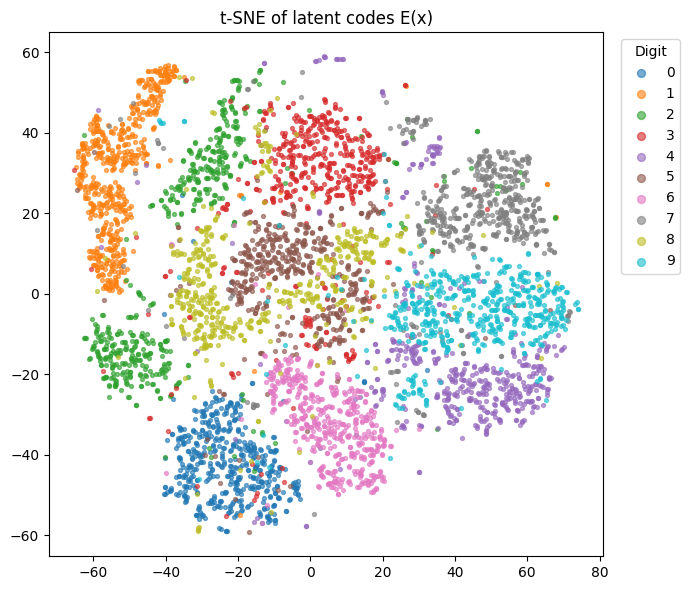

In [9]:
# t-SNE로 E(x)의 잠복공간 분포 시각화
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

E.eval()
Z_list, Y_list = [], []
N = 5000  # 시각화 샘플 수(속도-품질 균형: 2k~10k 추천)
seen = 0

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        z = E(x)
        Z_list.append(z.cpu())
        Y_list.append(y)
        seen += x.size(0)
        if seen >= N:
            break

Z = torch.cat(Z_list, 0)[:N].numpy()
Y = torch.cat(Y_list, 0)[:N].numpy()

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
Z2 = tsne.fit_transform(Z)

plt.figure(figsize=(7, 6))
for d in range(10):
    idx = (Y == d)
    plt.scatter(Z2[idx, 0], Z2[idx, 1], s=8, alpha=0.6, label=str(d))
plt.legend(title="Digit", markerscale=2, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.title("t-SNE of latent codes E(x)")
plt.tight_layout()
plt.show()